In [144]:
import sys
from io import StringIO
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score,RocCurveDisplay, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


In [145]:
def clean_data(X: np.ndarray) -> np.ndarray:
    """"
    Cleans the dataset X. Removes terms that appear in less than 3 documents.

    :type X: scipy.sparse.csr.csr_matrix
    :param X: sparse matrix of shape (n_words, n_docs)
    :return: cleaned matrix of shape (n_words, n_docs)
    """
    x_arr = X.toarray() #tranform to array from Sparse matrix
    freq = np.sum(x_arr,axis=0).reshape(-1,1) #sums the number of documents each word appears in
    low_freq = np.nonzero(freq<3) #finds the indices of the words that appear in less than 3 documents
    x_arr = np.delete(x_arr,low_freq[0],axis=1) #deletes the words that appear in less than 3 documents
    return x_arr

def tf_idf(x_arr: np.ndarray) -> np.ndarray:
    """
    Calculates the tf-idf matrix of a given matrix.

    tf-idf function. Takes in a matrix X and returns a tf-idf matrix.
    term frequency (tf) -> number of times a word appears in a document divided by the total number of words in the document.
    inverse document frequency (idf) -> log of the total number of documents divided by the number of documents containing the word.

    :param x_arr: array of shape (n_words, n_docs)
    :return: tf-idf matrix of shape (n_words, n_docs)
    """
    #calculate term frequency
    tf = x_arr/np.sum(x_arr,axis=1).reshape(-1,1) # axis=1 means row # axis=0 means column
    #calculate inverse document frequency
    df = np.sum(x_arr, axis =0).reshape(-1,1)
    n_docs = x_arr.shape[1]
    idf = np.log(n_docs/(df+1))
    #calculate tf-idf
    tf_idf = tf*idf.reshape(1,-1)

    return tf_idf


def return_metrics(classifier, y_test, x_test) -> tuple:
    """
    Calculates the accuracy, f1 score and roc_auc score of a classifier.

    :type classifier: sklearn.linear_model._stochastic_gradient.SGDClassifier
    :param classifier: trained classifier
    :param y_test: array of shape (n_samples, )
    :param x_test: array of shape (n_features, n_samples)
    :return: tuple of metrics (accuracy, f1, roc_auc)
    """
    ac_clf = accuracy_score(y_test,classifier.predict(x_test))
    f1_clf = f1_score(y_test,classifier.predict(x_test))
    roc_auc = roc_auc_score(y_test,classifier.predict(x_test))
    return ac_clf, f1_clf, roc_auc

def train_classifier(clf, x_train: np.ndarray , y_train: np.ndarray) -> tuple:
    """
    Wrapper function that enables capturing the training loss history of a classifier.

    :type clf: sklearn.linear_model._stochastic_gradient.SGDClassifier
    :param clf: classifier
    :param x_train: array of shape (n_features, n_samples)
    :param y_train: array of shape (n_samples, )
    :return: trained classifier and loss history
    """
    ld_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    clf.fit(x_train,y_train.ravel())
    loss_history = mystdout.getvalue()
    loss_list = []

    for line in loss_history.split('\n'):
        if(len(line.split("loss: ")) == 1):
            continue
        loss_list.append(float(line.split("loss: ")[-1]))
    return clf, loss_list

def plot_loss(loss_history: list, clf_name: str = 'Classifier') -> None:
    """
    Plots the training loss of a classifier.

    :param loss_history: list of loss values
    :param clf_name: name of the classifier
    :return: None
    """
    plt.figure()
    plt.plot(np.arange(len(loss_history)), loss_history)
    plt.xlabel("Time in epochs"); plt.ylabel(f"Loss {clf_name}")
    plt.show()

def unpack_data(file: str) -> tuple:
    """
    Unpacks the data from a .mat file.
    Transposes the matrices.
    Cleans the dataset.
    Calculates the tf-idf matrix.


    :param file: path to the .mat file
    :return: tuple of data (X, Y)
    """
    data = sio.loadmat(file)
    X = data['X']
    Y = data['Y']
    X_tp= np.transpose(X)
    Y_tp = np.transpose(Y)
    x_clean = clean_data(X_tp)
    x_tf_idf = tf_idf(x_clean) #used for cv and grid search cv

    return x_tf_idf, Y_tp

In [ ]:
x_tf_idf, Y = unpack_data('data/emails.mat')
x_train, x_test, y_train, y_test = train_test_split(x_tf_idf,Y.ravel(), test_size = 0.2,shuffle = True, random_state = 42, stratify = Y)


In [120]:
#SVM Classifier

svm_classifier = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-05, verbose = 1)
svm_classifier, svm_loss = train_classifier(svm_classifier, x_train, y_train.ravel())

ac_svm, f1_svm, roc_auc_svm = return_metrics(svm_classifier, y_test, x_test)

In [121]:
#Logistic Regression Classifier
logreg_classifier = SGDClassifier(loss = 'log_loss', penalty = 'l2', alpha = 1e-05, verbose = 1)
logreg_classifier, logreg_loss = train_classifier(logreg_classifier, x_train, y_train.ravel())
ac_logreg, f1_logreg, roc_auc_logreg = return_metrics(logreg_classifier, y_test, x_test)

In [122]:
#Random Forest Classifier
#{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', #'max_depth': 80, 'bootstrap': False}
rf_classifier = RandomForestClassifier(n_estimators=1000, min_samples_split=10,
                                       min_samples_leaf=1, max_features='auto',
                                       max_depth=80, bootstrap=False, verbose = 1)

rf_classifier, rf_loss = train_classifier(rf_classifier, x_train, y_train.ravel())
ac_rf, f1_rf, roc_auc_rf = return_metrics(rf_classifier, y_test, x_test)

/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 23.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


In [124]:
#Ensemble Voting Classifier
clf_1 = SGDClassifier(loss = 'log_loss', penalty = 'l2', alpha = 1e-08) #SVM Classifier
clf_2 = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-08) #Logistic Regression Classifier
clf_3 = RandomForestClassifier(n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=60, bootstrap=False) #Random Forest Classifier

eclf = VotingClassifier(estimators=[('logreg', clf_1), ('svm', clf_2), ('rf', clf_3)],voting='hard', verbose = 1)
eclf.fit(x_train, y_train.ravel())
ac_eclf, f1_eclf, roc_auc_eclf = return_metrics(eclf, y_test, x_test)


In [142]:
metric_dict = {'SVM':{'accuracy':ac_svm,
                      'f1_score':f1_svm,
                      'roc_auc_score':roc_auc_svm},

               'Logistic Regression':{'accuracy':ac_logreg,
                                      'f1_score':f1_logreg,
                                      'roc_auc_score':roc_auc_logreg},

                'Random Forest':{'accuracy':ac_rf,
                                 'f1_score':f1_rf,
                                 'roc_auc_score':roc_auc_rf},

                'Ensemble Voting':{'accuracy':ac_eclf,
                                   'f1_score':f1_eclf,
                                   'roc_auc_score':roc_auc_eclf}
}

with open("metrics.json", "w") as outfile:
    json.dump(metric_dict, outfile)

In [143]:
#evaluation metrics
print('Evaluation Metrics')
print('#-------------------#')
print('SVM Classifier')
print('Accuracy: ',ac_svm)
print('F1 Score: ',f1_svm)
print('roc_auc_score: ',roc_auc_svm)
print('#-------------------#')
print('Logistic Regression Classifier')
print('Accuracy: ',ac_logreg)
print('F1 Score: ',f1_logreg)
print('roc_auc_score: ',roc_auc_logreg)
print('#-------------------#')
print('Random Forest Classifier')
print('Accuracy: ',ac_rf)
print('F1 Score: ',f1_rf)
print('roc_auc_score: ',roc_auc_rf)
print('#-------------------#')
print('Ensemble Voting Classifier')
print('Accuracy: ',ac_eclf)
print('F1 Score: ',f1_eclf)
print('roc_auc_score: ',roc_auc_eclf)
print('#-------------------#')

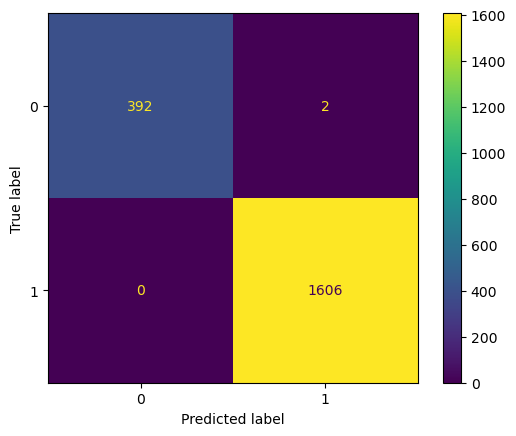

In [126]:
#confusion matrix SVM
cm_svm_classifier = confusion_matrix(y_test, svm_classifier.predict(x_test))
display = ConfusionMatrixDisplay(cm_svm_classifier).plot()
plt.show()


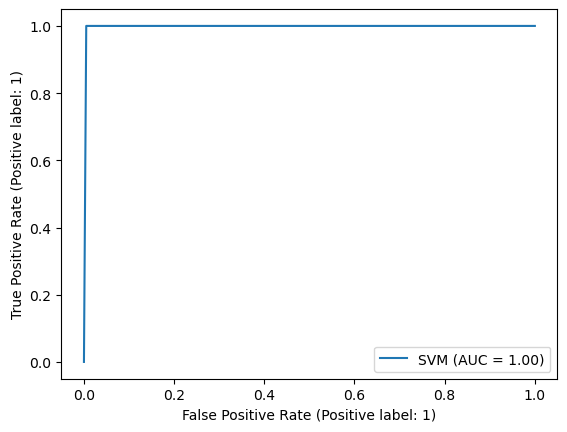

In [127]:
#ROC curve SVM
roc_svm = RocCurveDisplay.from_predictions(y_test, svm_classifier.predict(x_test), name = 'SVM')


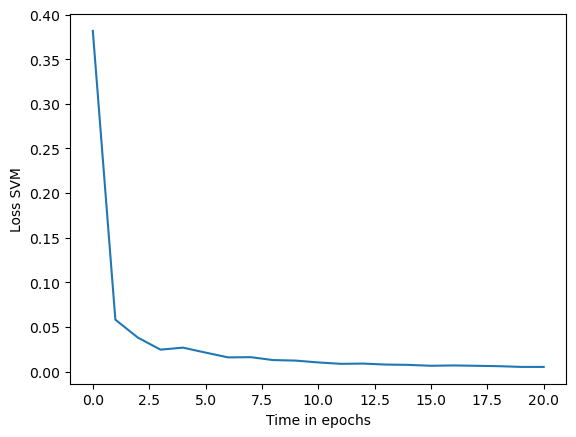

In [128]:
plot_loss(svm_loss, 'SVM')

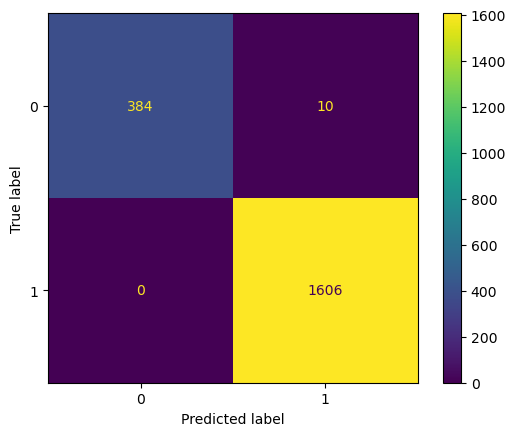

In [129]:
#confusion matrix Logistic Regression
cm_logreg_classifier = confusion_matrix(y_test, logreg_classifier.predict(x_test))
display = ConfusionMatrixDisplay(cm_logreg_classifier).plot()
plt.show()

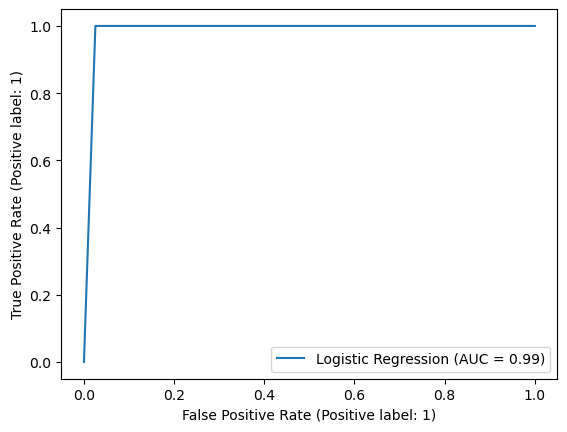

In [130]:
#ROC curve Logistic Regression
roc_logreg = RocCurveDisplay.from_predictions(y_test, logreg_classifier.predict(x_test), name = 'Logistic Regression')

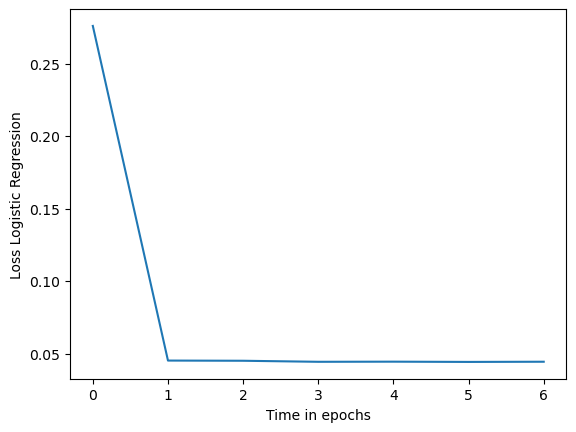

In [131]:
plot_loss(logreg_loss, 'Logistic Regression')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


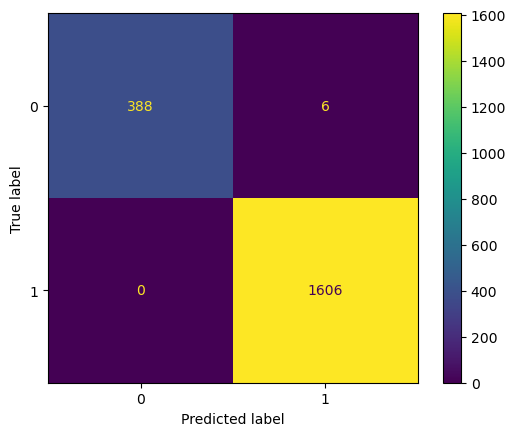

In [132]:
#confusion matrix Random Forest
cm_rf_classifier = confusion_matrix(y_test, rf_classifier.predict(x_test))
display = ConfusionMatrixDisplay(cm_rf_classifier).plot()
plt.show()


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.6s finished


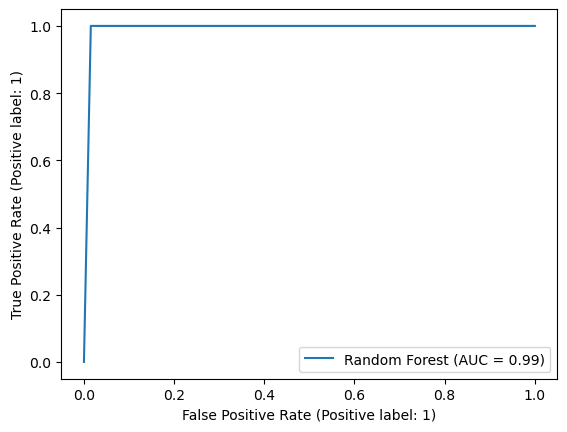

In [133]:
#ROC curve Random Forest
roc_rf = RocCurveDisplay.from_predictions(y_test, rf_classifier.predict(x_test), name = 'Random Forest')


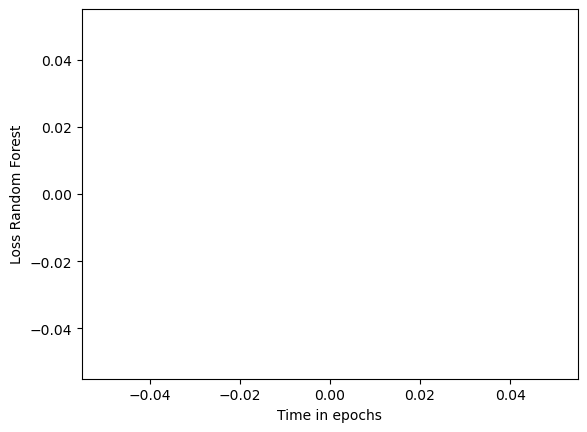

In [134]:
plot_loss(rf_loss, 'Random Forest')

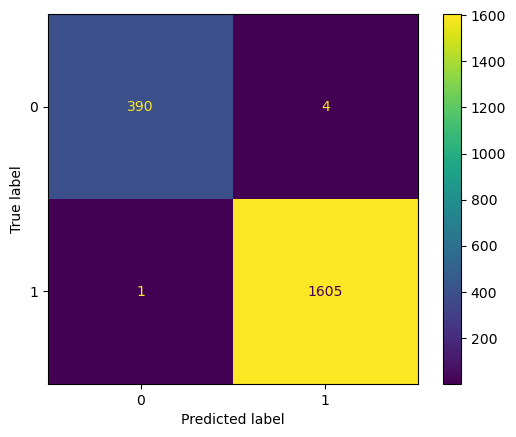

In [135]:
#confusion matrix Ensemble Voting Classifier
cm_eclf = confusion_matrix(y_test, eclf.predict(x_test))
display = ConfusionMatrixDisplay(cm_eclf).plot()
plt.show()


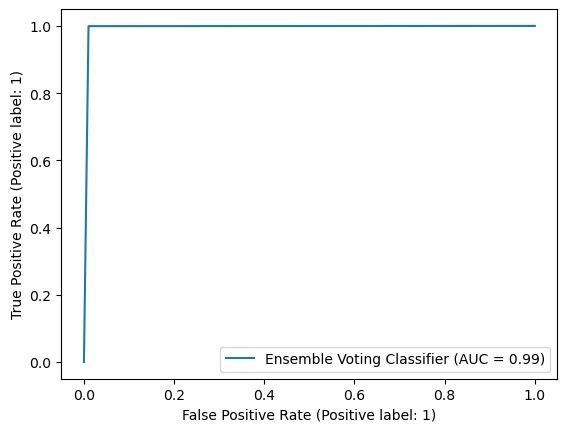

In [136]:
#ROC curve Ensemble Voting Classifier
roc_eclf = RocCurveDisplay.from_predictions(y_test, eclf.predict(x_test), name='Ensemble Voting Classifier')

In [81]:
#grid search parameters

#params for logreg and svm
param_grid =  {'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
               'penalty' : ['l2','l1']
     }
#params for random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [90]:
#grid search for SVM
svm_search = SGDClassifier(loss='hinge', random_state=42)
svm_random= GridSearchCV(svm_search, param_grid, cv=3, verbose = 2, scoring ='roc_auc')
svm_random.fit(x_tf_idf, Y.ravel())
print(svm_random.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ............................alpha=1e-08, penalty=l2; total time=  14.2s
[CV] END ............................alpha=1e-08, penalty=l2; total time=  13.1s
[CV] END ............................alpha=1e-08, penalty=l2; total time=  13.9s
[CV] END ............................alpha=1e-08, penalty=l1; total time=  32.3s
[CV] END ............................alpha=1e-08, penalty=l1; total time=  26.7s
[CV] END ............................alpha=1e-08, penalty=l1; total time=  26.6s
[CV] END ............................alpha=1e-07, penalty=l2; total time=  13.5s
[CV] END ............................alpha=1e-07, penalty=l2; total time=  15.0s
[CV] END ............................alpha=1e-07, penalty=l2; total time=  22.0s
[CV] END ............................alpha=1e-07, penalty=l1; total time=  42.2s
[CV] END ............................alpha=1e-07, penalty=l1; total time=  30.7s
[CV] END ............................alpha=1e-07

In [91]:
#grid search for logistic regression
logreg_search = SGDClassifier(loss='log_loss', random_state=42)
logreg_random= GridSearchCV(logreg_search, param_grid,cv=3,verbose = 2, scoring ='roc_auc')
logreg_random.fit(x_tf_idf, Y.ravel())
print(logreg_random.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ............................alpha=1e-08, penalty=l2; total time=  28.9s
[CV] END ............................alpha=1e-08, penalty=l2; total time=  27.2s
[CV] END ............................alpha=1e-08, penalty=l2; total time=  26.5s
[CV] END ............................alpha=1e-08, penalty=l1; total time=  42.8s
[CV] END ............................alpha=1e-08, penalty=l1; total time= 1.1min
[CV] END ............................alpha=1e-08, penalty=l1; total time= 1.5min
[CV] END ............................alpha=1e-07, penalty=l2; total time=  20.3s
[CV] END ............................alpha=1e-07, penalty=l2; total time=  24.2s
[CV] END ............................alpha=1e-07, penalty=l2; total time=  31.9s
[CV] END ............................alpha=1e-07, penalty=l1; total time=  43.7s
[CV] END ............................alpha=1e-07, penalty=l1; total time=  42.3s
[CV] END ............................alpha=1e-07

In [87]:
#grid search for random forest
rf_search = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_search,scoring ='roc_auc', param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42)
rf_random.fit(x_tf_idf, Y.ravel())

print(rf_random.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  30.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  31.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  26.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 1.2min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 1.7min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time= 1.9min


/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.2min


/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.9min


/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 2.1min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 1.5min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 2.3min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time= 2.0min


/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 1.9min


/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 3.0min


/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.7min


/Users/dicaristic/miniforge3/envs/Final Project/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}
